In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import snowflake.connector as sf
con = sf.connect(
    user='rian.firmansyah@superbank.id',
    account='superbank-prd',
    authenticator='externalbrowser',
    warehouse='ANALYTICS_HELPER_WH',
    database='ANALYTICS_SANDBOX',
    schema='SANDBOX_RIAN',
    session_parameters={
        'TIMEZONE': 'Asia/Jakarta',
    }
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.jumpcloud.com/saml2/snowflake_prd?SAMLRequest=lZJBT%2BMwEIX%2FSuQ9J3ZSVoDVFmWJEJFot6KhK3FZuYlb3Dh28Nik%2FHuchCL2ANLeLPu9mW%2F8Znp1bGTwwg0IrWYojggKuCp1JdR%2Bhh6Km%2FACBWCZqpjUis%2FQKwd0NZ8Ca2RLU2ef1D1%2Fdhxs4AspoMPDDDmjqGYggCrWcKC2pOt0cUeTiNDWaKtLLdEny%2FcOBsCN9YQnSwXC4z1Z21KMu66LukmkzR4nhBBMLrFX9ZIfJ%2F3Rz%2FSFPsbkrNd7hZev3tl%2BCTV%2BwXdY21EE9LYoVuHq97pAQXpCvdYKXMPNmpsXUfKH%2B7sRADwBuJabLVN12JoqAqW7nWQ1L3XTOusrRv6Ed7zCUu%2BFHzrPZqitRbX5kxx45mqhtxePknRx6p5FsYyPl4t0czjUeZYtF7cTvl%2FXJQo2p1STPtUcwPFc9Vlaf0WSnyGZhHFSkJjG53RCovjs%2FBEFmc9SKGYH5wcw6OjgmraU2lUDXR9agj%2FQ%2F%2FpB0LgWdOhk5v8z7BR%2Fdr5v19J%2FeJ6ttBTla3CjTcPs13nEUTzciCrcDVLKGyZkWlWGA%2FhcpNTdteHM%2BiW2xnGE52PXf9d4%2FgY%3D&RelayState=ver%3A1-hint%3A10209147693126-ETMsDgAAAZW

In [5]:
def run_query(query):
    cur = con.cursor()
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    cur.close()
    return df

In [9]:
query1 = """
SELECT 
    RIGHT(DATE(account_open_date),2) AS date_open, 
    COUNT(DISTINCT safe_id) AS total_accounts
FROM silver.core.term_deposit
WHERE CURRENT_DATE BETWEEN _hfh_valid_from AND _hfh_valid_to
GROUP BY date_open;
"""

df1 = run_query(query1)

In [13]:
query2 = """
SELECT 
    RIGHT(DATE(account_open_date),2) AS date_open, 
    HOUR(account_open_date) AS hour_open, 
    COUNT(DISTINCT safe_id) AS total_user, 
    SUM(prin_available_amt_ori) AS amount
FROM silver.core.term_deposit
WHERE CURRENT_DATE BETWEEN _hfh_valid_from AND _hfh_valid_to
GROUP BY 1,2;
"""

df2 = run_query(query2)

In [17]:
df2["DATE_OPEN"] = df2["DATE_OPEN"].astype(int)
df2["HOUR_OPEN"] = df2["HOUR_OPEN"].astype(int)

/var/folders/wg/7ssw3c_10gx47bc0rgbzh3qw0000gn/T/ipykernel_64939/899064095.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df1["DATE_OPEN"], y=df1["TOTAL_ACCOUNTS"], palette="Blues_r")


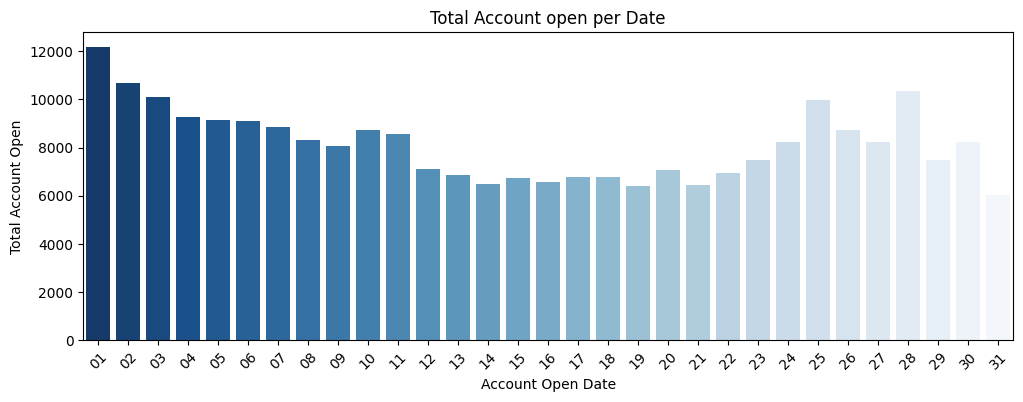

In [39]:
df1 = df1.sort_values(by="DATE_OPEN", ascending=True)

# **HEATMAP 1: Total Akun per Tanggal**

plt.figure(figsize=(12, 4))
sns.barplot(x=df1["DATE_OPEN"], y=df1["TOTAL_ACCOUNTS"], palette="Blues_r")
plt.xlabel("Account Open Date")
plt.ylabel("Total Account Open")
plt.title("Total Account open per Date")
plt.xticks(rotation=45)
plt.show()

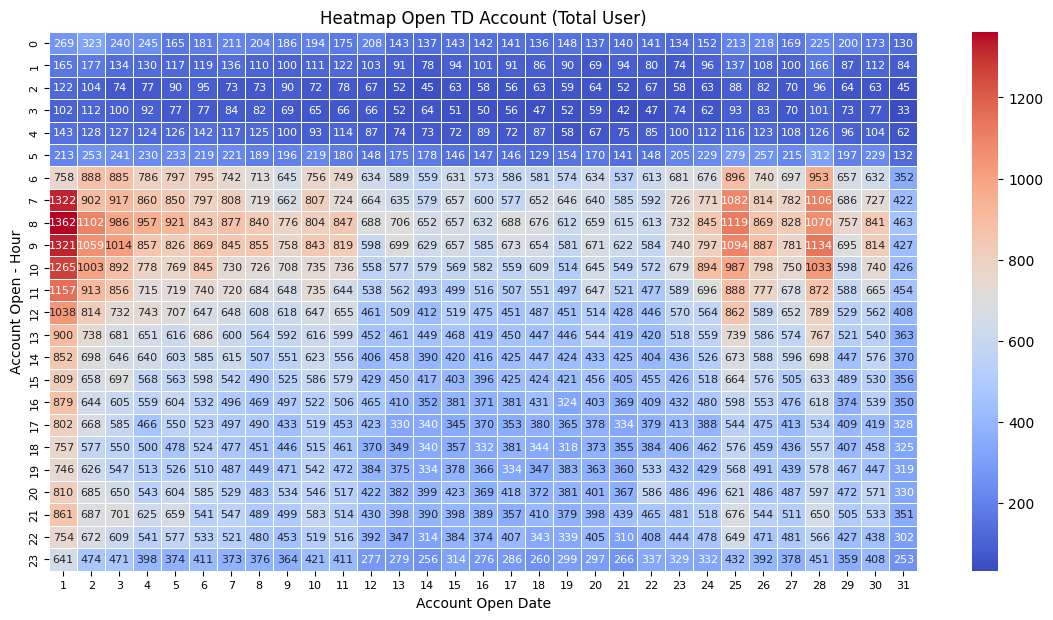

In [25]:
# Pivot data untuk heatmap
heatmap_data = df2.pivot(index="HOUR_OPEN", columns="DATE_OPEN", values="TOTAL_USER")

# **HEATMAP 2
plt.figure(figsize=(14, 7)) 

sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    annot_kws={"size": 8} 
)

plt.xlabel("Account Open Date", fontsize=10)
plt.ylabel("Account Open - Hour", fontsize=10)
plt.title("Heatmap Open TD Account (Total User)", fontsize=12)

plt.xticks(fontsize=8) 
plt.yticks(fontsize=8) 

plt.show()

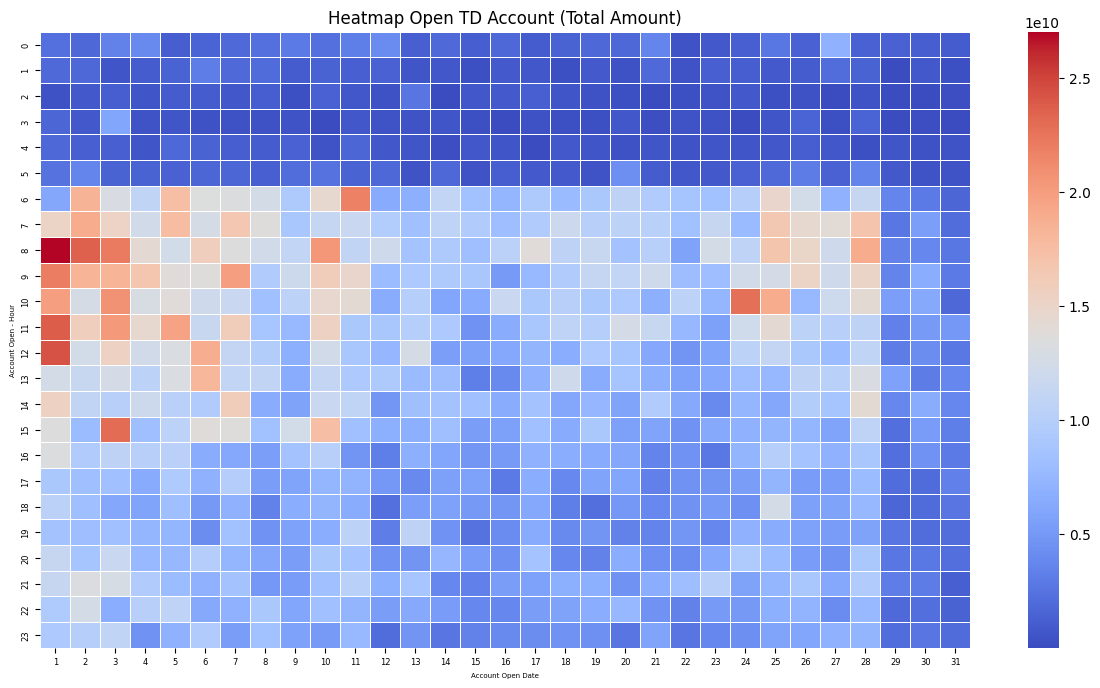

In [33]:
# Pivot data untuk heatmap
heatmap_data = df2.pivot(index="HOUR_OPEN", columns="DATE_OPEN", values="AMOUNT")

heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')

heatmap_data = heatmap_data.fillna(0)

# **HEATMAP 2: Total Amount**
plt.figure(figsize=(15, 8))

sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    ##annot=True,
    fmt=".0f",
    linewidths=0.5,
    annot_kws={"size": 8}
)

# Font styling
plt.xlabel("Account Open Date", fontsize=5)
plt.ylabel("Account Open - Hour", fontsize=5)
plt.title("Heatmap Open TD Account (Total Amount)", fontsize=12)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()